# Tutorial 1: Modeling a Pendulum

In the 2004 comedy "Dodgeball", there is a famous scene in which Patches O'Hoolihan, a dodgeball legend turned gruff eccentric, decides to train a group of desperate amateurs. At their first practice, however, Patches does not bring dodge balls; instead, he arrives with a large burlap sack. When asked how he could possibly teach them dodgeball without dodge balls, Patches proclaims, "If you can dodge a wrench, you can dodge a ball."-- upon which he reaches into his sack, produces a large wrench, and hurls it with deadly accuracy at the nearest forehead. 

In the world of dynamical systems, the pendulum is our wrench. If we consider the pendulum in its full wide-arc swing, it is a nonlinear system; if we consider the small-angle approximation near its equilibrium point, it is a linear system. We can represent it in both contrinuous and discrete time.  A standard pendulum rests in a stable equilibrium point; an inverted pendulum rests in an unstable equilibrium point.  If we can sucessfully model a control system that can balance an inverted pendulum, we can model any feedback system.

In this tutorial, we will build up to such a control system using `pykal_core`

## Defining a Dynamical System

We consider the canonical pendulum: a point mass $m$ in a constant gravitational field $g$, which is attached to the end of a massless rigid rod of constant length $l$. There is no air resistance or other dissipative resisteive forces. Such a system, with its corresponding state-space representation, is shown below:

<p align="center">
  <img src="../../_static/system_block_diagram.svg" alt="System Diagram" width="30%">
  <img src="../../_static/pendulum.svg" alt="Pendulum Diagram" width="25%">
  <img src="../../_static/pendulum_state_space.svg" alt="Pendulum State Space" width="25%">
</p>

Recall that the state-space model of a continuous-time dynamical system is given by:

$$
\begin{aligned}
\dot{x} &= f(x, u, t) + w(t) \\
y &= h(x, u, t) + r(t)
\end{aligned}
$$

Where:

- $x \in \mathbb{R}^{n}$ is the **state vector**
- $u \in \mathbb{R}^{p}$ is the **input vector**
- $t \in \mathbb{R}^{+}$ is **time**
- $w(t) \in \mathbb{R}^{n}$ is **process noise**, distributed as $w \sim \mathcal{N}(0, Q(t))$, where $Q(t) \in \mathbb{R}^{n \times n}$ is the **process noise covariance matrix**

Similarly:

- $y \in \mathbb{R}^{m}$ is the **measurement vector**
- $r(t) \in \mathbb{R}^{m}$ is **measurement noise**, distributed as $r \sim \mathcal{N}(0, R(t))$, where $R(t) \in \mathbb{R}^{m \times m}$ is the **measurement noise covariance matrix**

Note that there are four functions that define the behavior of the system: $f$, $h$, $w$, and $r$. We thus represent our dynamical system as an instance of a `System` class which binds together these functions. 

In [1]:
from pykal_core.control_system.system import System

sys = System(state_names=["x0","x1"]) # state names are the only required argument for the constructor

for key, value in sys.__dict__.items():
    print(f"{key}: {value}")

safeio: <pykal_core.control_system.system.System.SafeIO object at 0x7ff95da25bb0>
_state_names: ['x0', 'x1']
_measurement_names: ['x0_meas', 'x1_meas']
_system_type: cti
_f: <function System.f_zero at 0x7ff9867e99e0>
_h: <function System.h_identity at 0x7ff95c980220>
_Q: <function System.make_Q.<locals>.Q at 0x7ff99d151080>
_R: <function System.make_R.<locals>.R at 0x7ff99dc0e980>


Note that the `sys` object is initialized with several default attributes if they are not passed to the constructor. The `System.safeio` object is an instance of utility subclass which is composed with all instances of `System`; it is used by other classes that interface with `sys` and is not normally used by users. For information about `System.safeio`, see Tutorial 0. 

### Default `sys` Attribute Values

`sys._measurement_names` are the default measurement names (assumed to be full-state measurements) 

In [26]:
sys.measurement_names

['x0_meas', 'x1_meas']

`sys.system_type` is the time structure of the dynamical system (default is "cti", or "continuous time-invariant")

In [19]:
sys.system_types # all available system time structures for sys

{'cti', 'ctv', 'dti', 'dtv'}

`System.f_zero` is the function $f(x,u,t) = 0$ ie a dynamical system that does not change over time


In [22]:
import numpy as np
xk = np.array([[1.0], [0.0]])
sys.f(xk)

array([[0.],
       [0.]])

`System.h_identity` is the function $h(x,u,t)=x$ ie the measurements are simply the state.

In [23]:
xk = np.array([[1.0], [0.0]])
sys.h(xk)

array([[1.],
       [0.]])


`System.make_Q.<locals>.Q` is the process noise covariance $Q$ created by a factory function `System.make_Q`. The default $Q$ returns an identity matrix with noise $0.01$ on the diagonals.


In [27]:
sys.Q()

array([[0.01, 0.  ],
       [0.  , 0.01]])

`System.make_R.<locals>.Q` is the measurement noise covariance $R$ created by a factory function `System.make_R`. The default $R$ returns an identity matrix with noise $0.01$ on the diagonals.

In [28]:
sys.R()

array([[0.01, 0.  ],
       [0.  , 0.01]])

### Simulating a Dynamical System
Given an initial condition, we can simulate the dynamics of our system forward in time. As our dynamics functions is $f(x,u,t)=0$ with nonzero noise, we would be right to expect flat and noisy state trajectories.

<Axes: title={'center': 'States and Measurements'}, xlabel='time'>

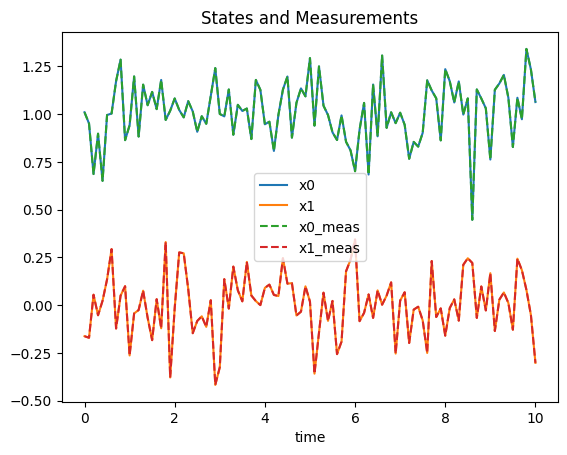

In [45]:
from pykal_core.utils import compute
import numpy as np

# Initial condition
x0 = np.array([[1.0], [0.0]])

# Simulate state trajectories
Xdf = compute.Simulation.of_state_trajectories(sys,
                                                x0=x0,
                                                t_span=(0,10),
                                                dt=0.1,
                                                output_df = True)

# Simulate measurements from the state trajectories
Ydf = compute.Simulation.of_measurements(sys,
                                        input_df=True,
                                        X_df= Xdf, 
                                        output_df=True)

# Plot both state and measurement trajectories
ax = Xdf.plot(title="States and Measurements")
Ydf.plot(ax=ax, style='--')  # Add measurements in dashed lines

Simulation of our dynamical system is very useful and can be used for sanity-checking and developing protytpes of control systems.

### Modifying `sys` after initialization
While we could have initialized the system with f and h, we set them now. We also change Q and R. 

In [2]:
from numpy.typing import NDArray
import numpy as np

def f_pendulum(xk: NDArray) -> NDArray:  # k = m = 1
    A = np.array([[0, 1],
                    [-1, 0]])  
    return A @ xk

sys.f = f_pendulum

sys.Q = sys.make_Q(state_names=["x0","x1"],
                    create_Q_from_list_of_floats=[0.01,0.2])

sys.R = sys.make_R(measurement_names=sys.measurement_names,
            multiply_eye_by_scalar=[0.1])

### Simulating a dynamical system
We can simulate the system to ensure its behavoiur:

<Axes: xlabel='time'>

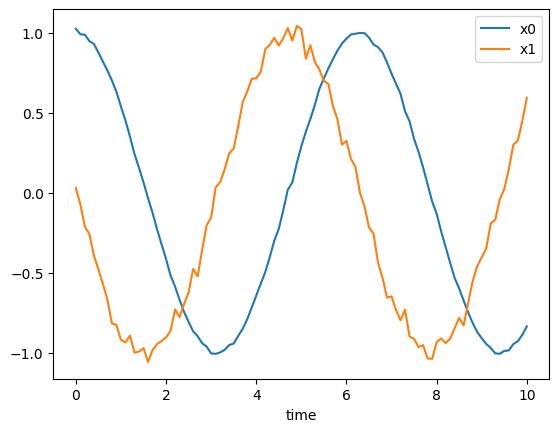

In [6]:
from pykal_core.utils import compute

x0 = np.array([[1.0], [0.0]])
Xdf = compute.Simulation.of_state_trajectories(sys,
                                                x0=x0,
                                                t_span=(0,10),
                                                dt=0.1,
                                                output_df = True)
Xdf.plot()

### Instantiate a new sys object from an old one
 We can also express this system as dti. We make a new sys object from the old one.


#+RESULTS:
:results:
:end:


  #+begin_src python

    Xdf.plot()


In [8]:
import copy
def f_pendulum_discrete(xk:NDArray) -> NDArray:
    A = np.array([[0, 1],
                    [-1, 0]])  
    return A @ xk      

sys_dti = copy.deepcopy(sys) # sys_dti points to new object in memory
sys_dti.f = f_pendulum_discrete
sys_dti.system_type = "dti"

We can confirm the equivalence by simulation:


<Axes: xlabel='time'>

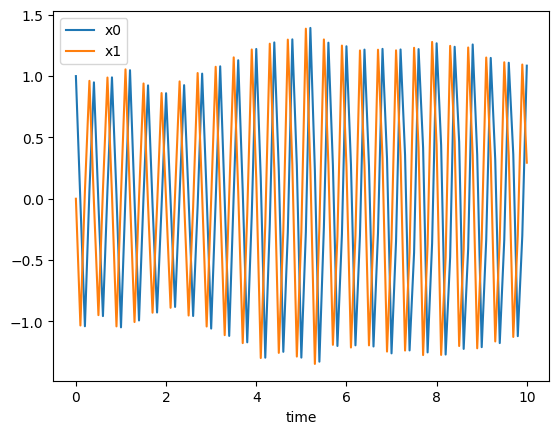

In [15]:
from pykal_core.utils import compute

x0 = np.array([[1.0], [0.0]])
Xdf = compute.Simulation.of_state_trajectories(sys_dti ,# the simulation method accessess system type from the System object
                                                x0=x0,
                                                t_span=(0,10),
                                                dt=0.1,
                                                output_df = True) 

Xdf.plot()

### Override simulation parameters
But what if we want to change the dynamics, say for a different mass constant $m$ or rod length $l$?

It would be a bother to instantiate new sys with different functions and simulte them to find one we like. Thats why you can ovveride simulation parameters to explore these changes before you comit to them.

<Axes: xlabel='time'>

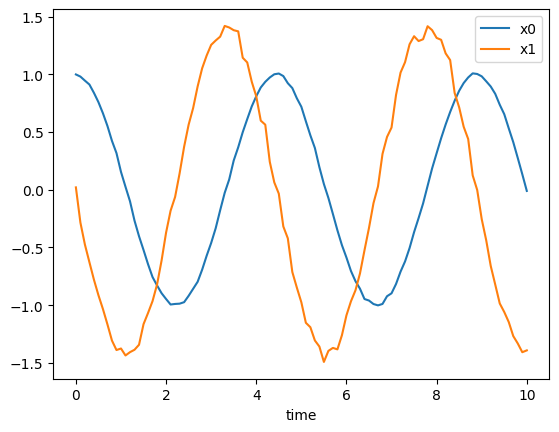

In [19]:
from typing import Callable

def make_pendulum_dynamics(*,l: float = 1.0, m: float = 1.0) -> Callable[[NDArray], NDArray]: # function factory ie a function that returns other functions
    def f_pendulum_dynamics_with_m_and_l(x: NDArray) -> NDArray:
        x1, x2 = x[0, 0], x[1, 0]
        dx1 = x2
        dx2 = - (l / m) * x1
        return np.array([[dx1], [dx2]])

    return f_pendulum_dynamics_with_m_and_l

x0 = np.array([[1.0], [0.0]])
Xdf = compute.Simulation.of_state_trajectories(sys,
                                                x0=x0,
                                                t_span=(0,10),
                                                dt=0.1,                                              
                                                override_system_f=make_pendulum_dynamics(l=2.0,m=1),
                                                output_df = True)
Xdf.plot()

Once satisfied, we can define a new sys object function

In [22]:
sys.f = make_pendulum_dynamics(l=2.0,m=1)
sys.f.__name__

'f_pendulum_dynamics_with_m_and_l'

## Defining a Signal

Consider a pendulum to which we apply a sinusoidal torque.
   <div style="display: flex; align-items: center; justify-content: space-between; gap: 2em; margin-top: 1em; margin-bottom: 1em;">
     <img src="../../_static/system_input_block_diagram.svg" alt="Signal System Diagram" style="width: 40%;">
     <img src="../../_static/pendulum_torque.svg" alt="Pendulum Torque Diagram" style="width: 20%;">
     <img src="../../_static/pendulum_torque_state_space.svg" alt="Pendulum State Space" style="width: 40%;">     
   </div>

### Building Functions with Functions
Note the use of a factory function to define a signal function. In pykal_core, whenever possible, functions are used in place of classes (e.g. a factory function that creates a sinusoidal function as opposed to some Sinusoidal class that instantiates a sin object with a signal method). This is for the sake of simplicity and, as we will see in the next section, ease in composing multiple signals. 


### Composing Signals

   <div style="display: flex; justify-content: center; margin-top: 1em; margin-bottom: 1em;">
     <img src="../../_static/system_input_multiple_block_diagram.svg" 
          alt="Multiple Signal System Diagram" 
          style="width: 60%;">
   </div>

.. raw:: html

   <div style="display: flex; justify-content: center; margin-top: 1em; margin-bottom: 1em;">
     <img src="../../_static/signals_combined.svg" 
          alt="Signal Composition" 
          style="width: 100%;">
   </div

## Composing Functions with Functions

At first glance, the signal.transform method may seem strange, as the arguments (a,b) to which our function (add) is applied are themselves functions and not, say, numpy arrays. This is because signal.transform does not return a transformed numpy array, but rather a new function (sig) which returns the transformed numpy array given the transformation and the functions we are transforming. This is an incredibly powerful paradigm, because we can now construct signals transformations of arbitrary complexity all in a single function, which makes representing said functin in  ros node much easier. Also, the sigmal need not be signal functions; it could be functions that return measurements (such as h) or estimated state (in the case of observers, shown next). This signal class does a lot of heavy lifting. 

## Defining an Observer

## Defining a Controller